In [1]:
import math

import matplotlib.pyplot as plt
import osmnx as ox
import google_streetview.api as gsv

from scipy.spatial import distance
from pathlib import Path
from IPython.display import Image
from shapely.ops import nearest_points
from shapely.geometry import LineString
from collections import defaultdict

api_loc = Path('api.key')
with open(api_loc,'r') as f:
    api_key = f.read().strip()
    
%matplotlib inline
ox.config(log_console=False, use_cache=True)

In [2]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
      
    taken from https://gist.github.com/jeromer/2005586#file-compassbearing-py-L31
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[1])
    lat2 = math.radians(pointB[1])

    diffLong = math.radians(pointB[0] - pointA[0])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [3]:
# specify that we're retrieving building footprint geometries
tags = {'building': True}

In [61]:
point = (41.008940245006116, 28.973811579420097)
#address = "Bahen Centre, Toronto, ON, Canada"

# Get our data

First, we take either a point or address and get the building shapes surrounding that area.

In [62]:
if point:
    gdf = ox.geometries_from_point(point, {'building':True}, dist=150)
    G = ox.graph_from_point(point, dist=1000,
                          dist_type='network', network_type='walk')

else:
    gdf = ox.geometries_from_address(address, {'building':True}, dist=150)
    G = ox.graph_from_address(address, dist=1000,
                          dist_type='network', network_type='walk')

/Users/alex/miniconda3/envs/buildings/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

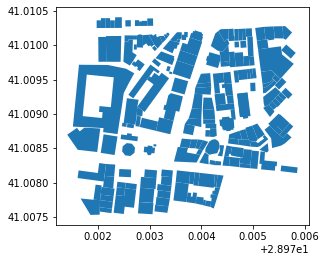

In [63]:
gdf.plot()

Next, we get the streets surrounding that same point.

In [64]:
nodes, edges = ox.graph_to_gdfs(G)

/Users/alex/miniconda3/envs/buildings/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

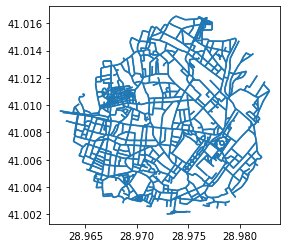

In [65]:
edges.plot()

Now we get the shape of the specific building we are looking for.

/Users/alex/miniconda3/envs/buildings/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

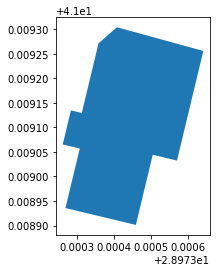

In [66]:
if point:
    gdf_mont = ox.geometries_from_point(point, tags, dist=25)
else:
    gdf_mont = ox.geometries_from_address(address, tags, dist=25)
p = gdf_mont.geometry[0]
gdf_mont[gdf_mont.index==0].plot()

Putting this all together, we have the data we need:

/Users/alex/miniconda3/envs/buildings/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

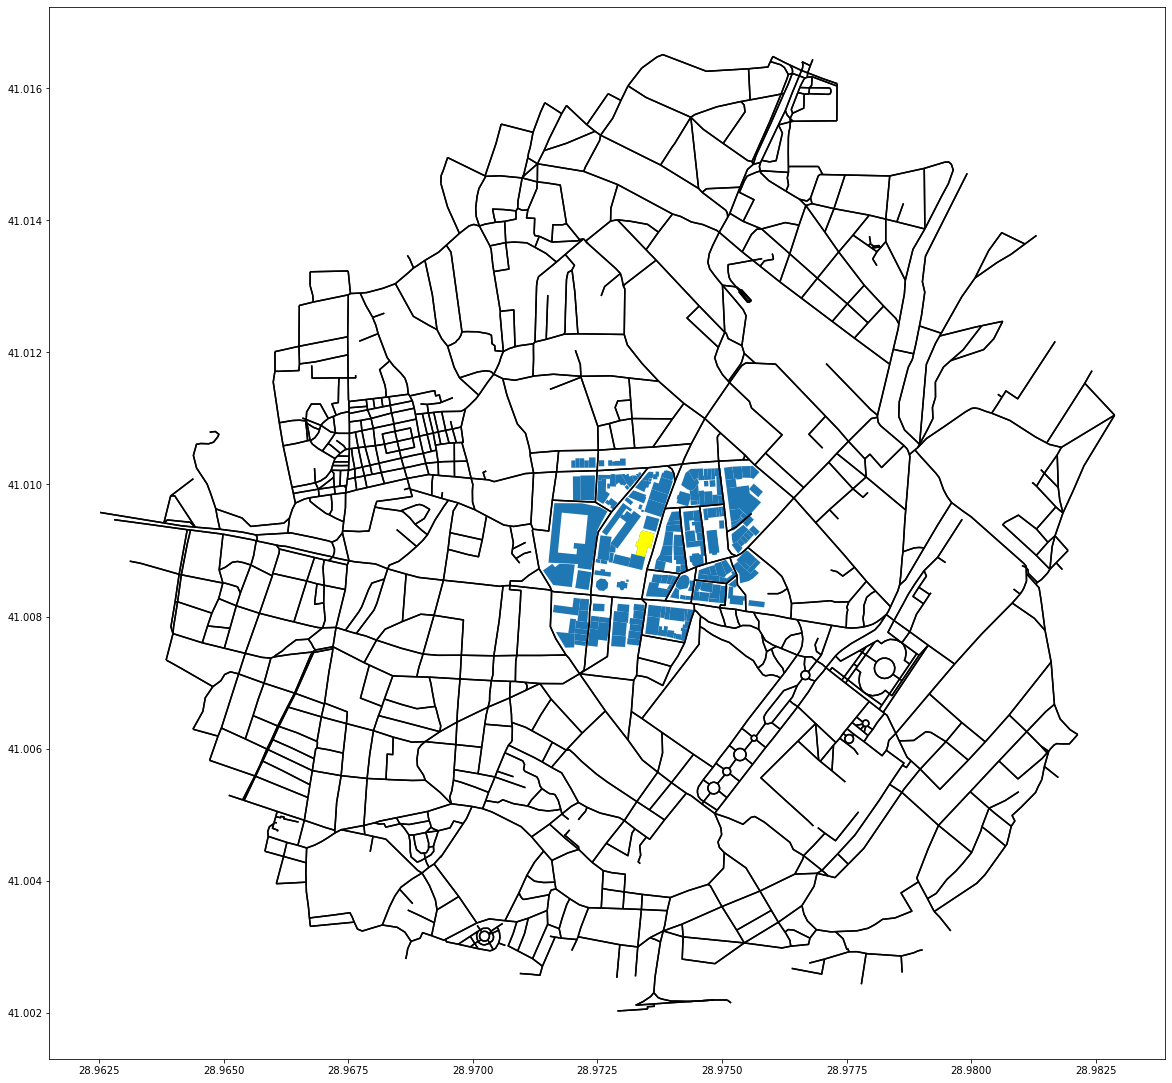

In [67]:
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax)
gdf_mont[gdf_mont.index==0].plot(ax=ax,color='yellow')
edges.plot(ax=ax,color='black')

We break down the shape of the building, and get the points at all its corners. These are what we want to photograph.

This approach is a shortcut to ensuring we photograph all sides of any shaped building. 

In [1]:
coords = list(p.exterior.coords)
X = [t[0] for t in coords]
Y = [t[1] for t in coords]
scatter = []
queries = []
plt.plot(X,Y);plt.scatter(X,Y)

NameError: name 'p' is not defined

Now, for each of the points on the building sides, we get the closest point on the road to that point. These are our initial estimates of where we should photograph from.

In [69]:
for a,b,_ in ox.get_nearest_edges(G,X,Y).tolist():
    try:
        l = G.get_edge_data(a, b)[0]['geometry']
    except:
        l = LineString([(G.nodes[a]['x'],G.nodes[b]['y']),(G.nodes[b]['x'],G.nodes[b]['y'])])
    np = nearest_points(l,p)[0]
    scatter.append(list(np.coords)[0])

<AxesSubplot:>

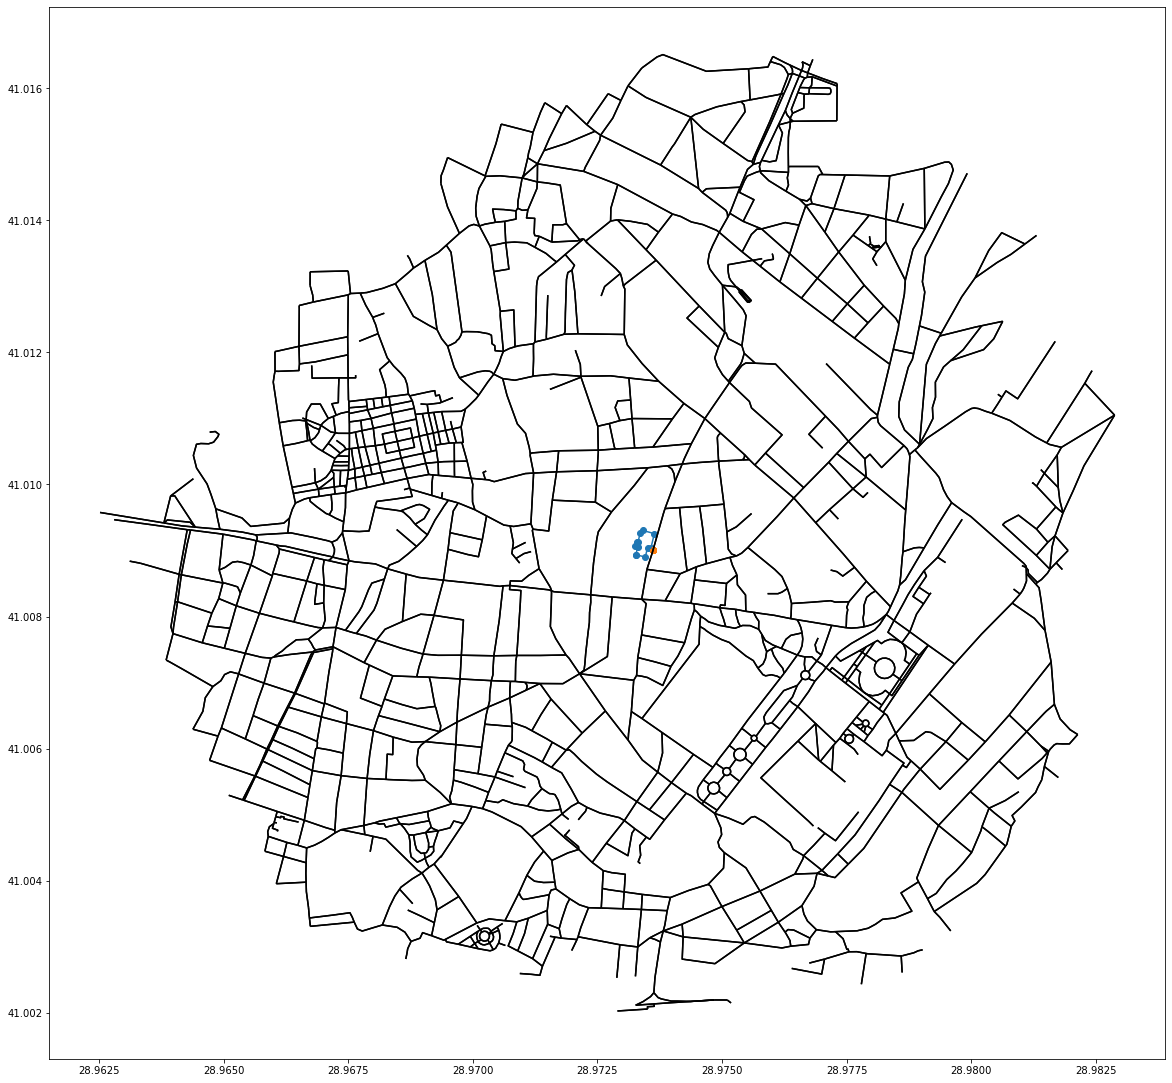

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
plt.plot(X,Y);plt.scatter(X,Y),plt.scatter([t[0] for t in list(scatter)],[t[1] for t in list(scatter)])
edges.plot(ax=ax,color='black')

In [71]:
pairs = defaultdict(lambda: [10000,0])
for point in scatter:
    for x,y in zip(X,Y):
        d = distance.euclidean((x,y),point)
        if pairs[point][0] > d:
            pairs[point][0] = d
            pairs[point][1] = (x,y)

/Users/alex/miniconda3/envs/buildings/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we have to figure out which points to remove because they are obstructed. This is a little tricky, but essentially we draw a line from each photograph point to the centre of the building, and then see if any other building in the area intersects that line.

In [72]:
toremove = []
for point,(_,(x,y)) in pairs.items():
    l = LineString([(x,y)] + [point])
    for _,building in gdf.iterrows():
        if point in scatter and building.geometry.intersects(l) and building.osmid != gdf_mont.osmid[0]:
            toremove.append(point)
scatter = set([p for p in scatter if p not in toremove])
for point in list(scatter):
    queries.append((point,calculate_initial_compass_bearing(point,list(p.centroid.coords)[0])))
X_scatter = [t[0] for t in list(scatter)]
Y_scatter = [t[1] for t in list(scatter)]

Now we have our candidate photograph points.

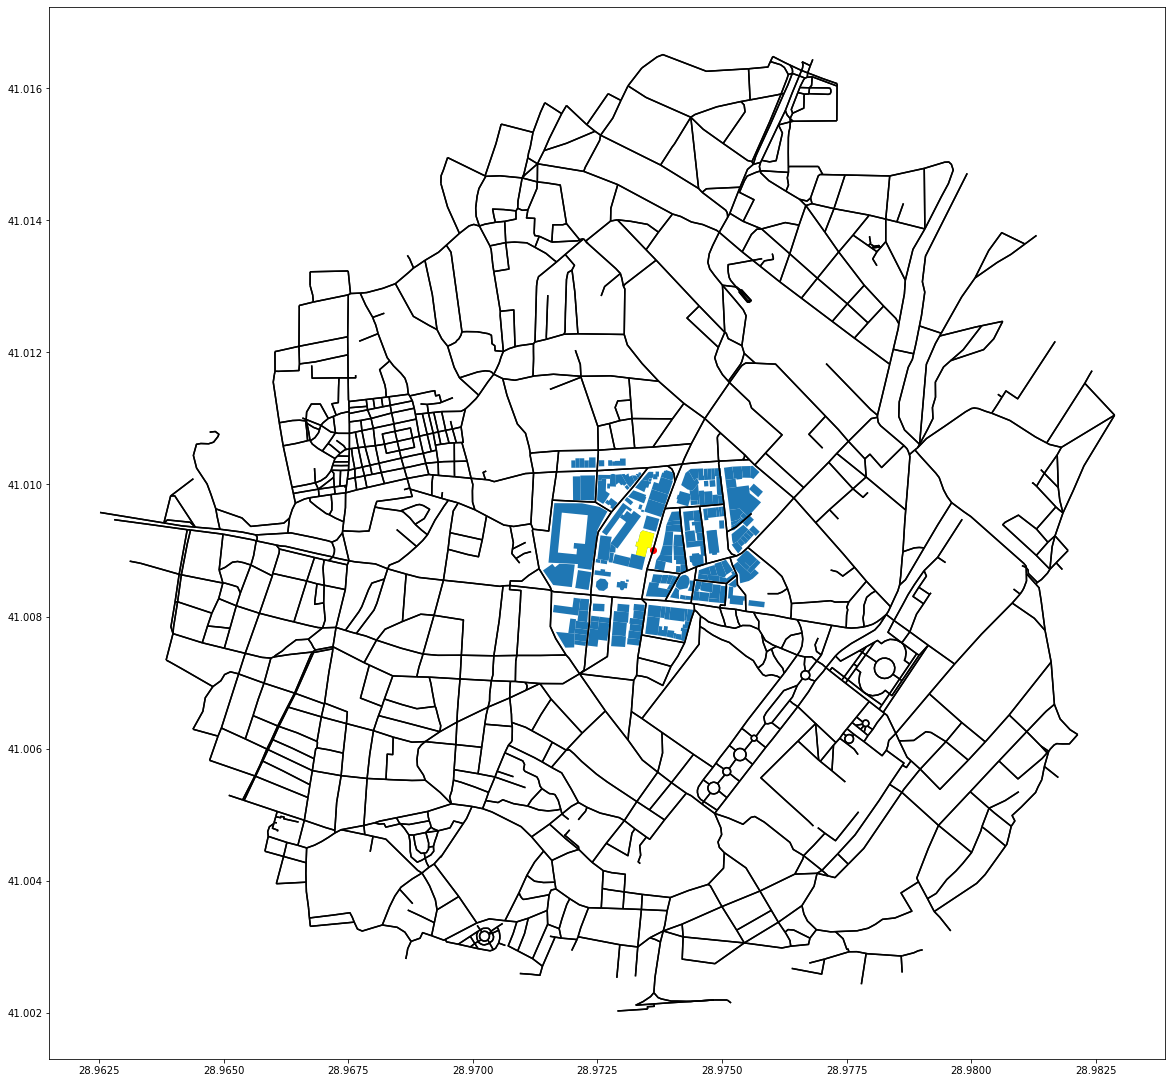

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax)
gdf_mont[gdf_mont.index==0].plot(ax=ax,color='yellow')
edges.plot(ax=ax,color='black')
plt.scatter(X_scatter,Y_scatter,color='red')

Now we can make the calls to the Google Maps API. For each candidate point, we give its location and the heading that would aim us to the building in question. We maximize the field of view, and we can optionally specify a pitch. 

In [74]:
params = []
for q in queries:
    for pitch in [0]:
        params.append({
            'size': '640x640', # max 640x640 pixels
            'location': f'{q[0][1]},{q[0][0]}', #Lat,Long
            'heading': q[1], #Angle to turn camera
            'fov':120, #Field of View (max 120)
            'pitch':pitch, #pitch (-90 for ground, +90 for sky)
            'key': api_key
        })

# Create a results object
results = gsv.results(params)

# Download results
results.download_links('downloads')

/Users/alex/miniconda3/envs/buildings/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
